<a href="https://colab.research.google.com/github/lissethz01/natural-images-classification/blob/main/natural_images_cnn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## CECS 456 - Deep Learning Project

**Dataset:** Natural Images (8 Classes)
- airplane, car, cat, dog, flower, fruit, person, motorbike



## 1. Setup and Import Libraries

In [4]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# this sets random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Upload dataset zip file
from google.colab import files
import zipfile

print("Please upload your natural-images.zip file:")
uploaded = files.upload()

# Extract the zip file
for filename in uploaded.keys():
    print(f"Extracting {filename}...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Extraction complete!")

# Sets the path to dataset
data_dir = '/content/natural_images'

# Verify the structure
if os.path.exists(data_dir):
    print(f"\nDataset found at: {data_dir}")
    print(f"Classes: {os.listdir(data_dir)}")
else:
    print("ERROR: Dataset not found. Please check the path.")

Please upload your natural-images.zip file:


Saving archive.zip to archive.zip
Extracting archive.zip...
Extraction complete!

Dataset found at: /content/natural_images
Classes: ['cat', 'person', 'flower', 'dog', 'motorbike', 'car', 'airplane', 'fruit']


## 3. Explore the Dataset

In [6]:
# to count images in each class
classes = sorted(os.listdir(data_dir))
print(f"Number of classes: {len(classes)}")
print(f"Class names: {classes}\n")

total_images = 0
print("Images per class:")
print("-" * 30)
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        total_images += num_images
        print(f"{class_name:15s}: {num_images:4d} images")

print("-" * 30)
print(f"Total images: {total_images}")

Number of classes: 8
Class names: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

Images per class:
------------------------------
airplane       :  727 images
car            :  968 images
cat            :  885 images
dog            :  702 images
flower         :  843 images
fruit          : 1000 images
motorbike      :  788 images
person         :  986 images
------------------------------
Total images: 6899


##  Sample Images

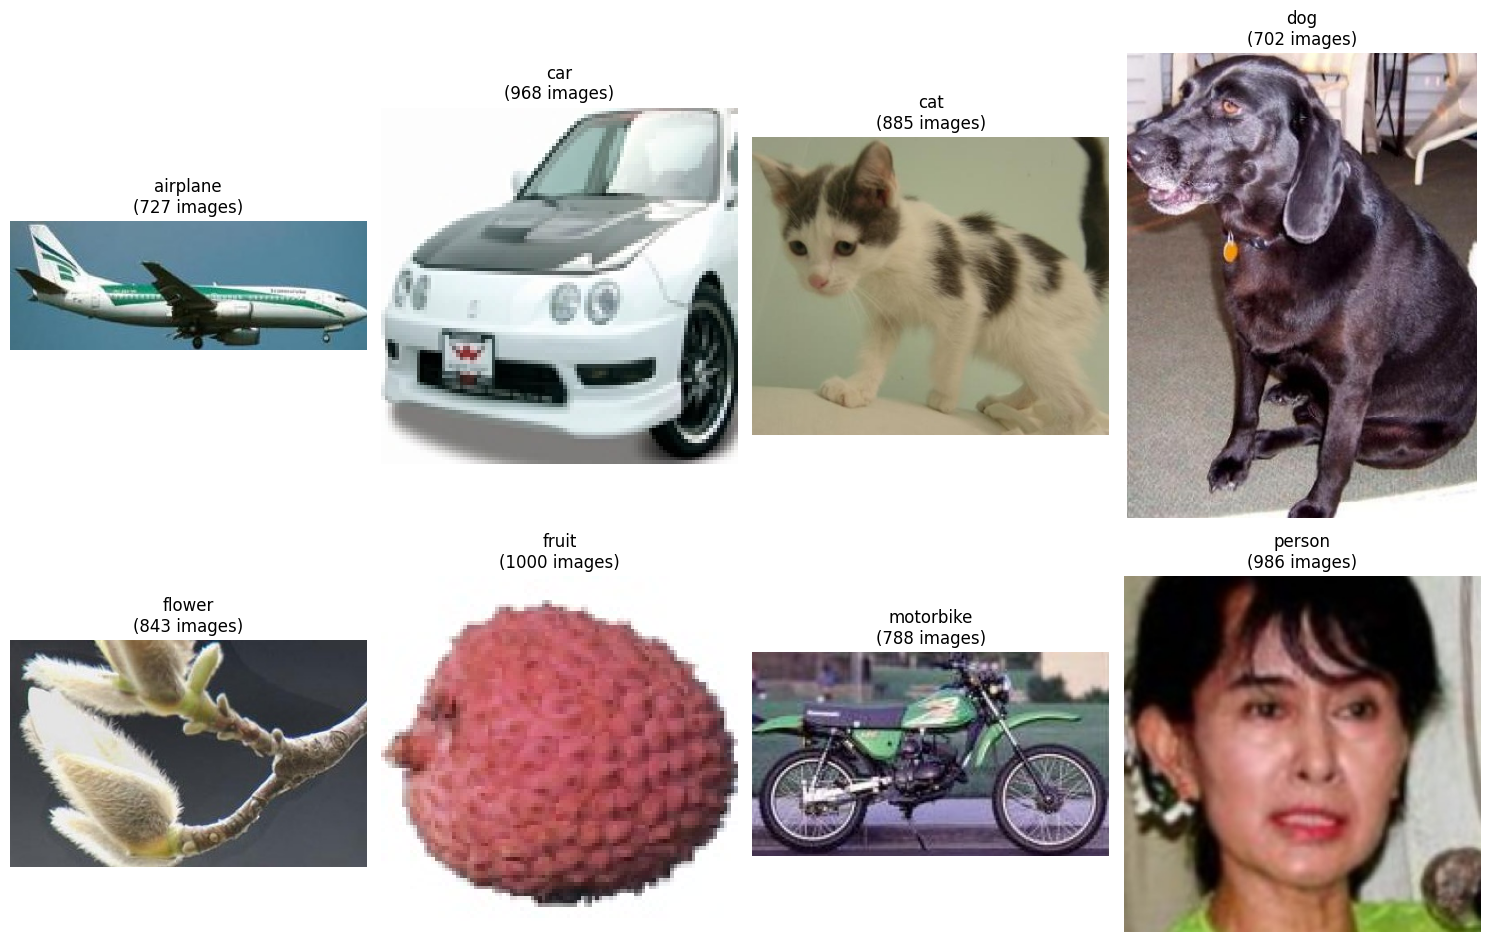

Sample images saved as 'sample_images.png'


In [7]:
# this displays sample images from each class
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        # Load first image from this class
        img_path = os.path.join(class_path, image_files[0])
        img = plt.imread(img_path)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"{class_name}\n({len(image_files)} images)", fontsize=12)
        plt.axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample images saved as 'sample_images.png'")

## Prepare Data with Augmentation


In [8]:
#parameters
IMG_SIZE = 150
BATCH_SIZE = 32

#Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    validation_split=0.2,        # Use 20% for validation
    rotation_range=20,           # Rotate images randomly up to 20 degrees
    width_shift_range=0.2,       # Shift horizontally by 20%
    height_shift_range=0.2,      # Shift vertically by 20%
    horizontal_flip=True,        # Flip images horizontally
    zoom_range=0.2,              # Zoom in/out by 20%
    fill_mode='nearest'          # Fill in missing pixels after transformations
)

# Training set
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation set
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.

Training samples: 5522
Validation samples: 1377
Number of classes: 8
Class indices: {'airplane': 0, 'car': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'fruit': 5, 'motorbike': 6, 'person': 7}


## Buildin and compile CNN Model


In [9]:
# Build the CNN model
model = keras.Sequential([
    # Input layer
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # thirdd convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # fourt convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # flatten and dense layers
    layers.Flatten(),
    layers.Dropout(0.5),                              # Prevent overfitting
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer
], name='Natural_Images_CNN')

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

# Count total parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

Model: "Natural_Images_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,553,864 (21.19 MB)

 Trainable params: 5,553,864 (21.19 MB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 5,553,864


## training the model


In [10]:
# training parameters
EPOCHS = 25

print(f"Starting training for {EPOCHS} epochs...\n")


history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

print("\nTraining complete!")


model.save('natural_images_cnn_model.h5')
print("Model saved as 'natural_images_cnn_model.h5'")

Starting training for 25 epochs...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.4292 - loss: 1.5184 - val_accuracy: 0.7066 - val_loss: 0.9322
Epoch 2/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 220ms/step - accuracy: 0.7441 - loss: 0.7347 - val_accuracy: 0.7836 - val_loss: 0.6057
Epoch 3/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.7793 - loss: 0.6049 - val_accuracy: 0.7727 - val_loss: 0.6527
Epoch 4/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.7806 - loss: 0.6054 - val_accuracy: 0.8119 - val_loss: 0.5323
Epoch 5/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.8144 - loss: 0.5190 - val_accuracy: 0.8613 - val_loss: 0.4200
Epoch 6/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 38s 219ms/step - accuracy: 0.8270 - loss: 0.4673 - val_accuracy: 0.8686 - val_loss: 0.3424
Epoch 7/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 0.8463 - loss: 0.4186 - val_accuracy: 0.8548 - val_loss: 0.4322
Epoch 8/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.8532 - loss: 0


Training complete!
Model saved as 'natural_images_cnn_model.h5'


## Training Results

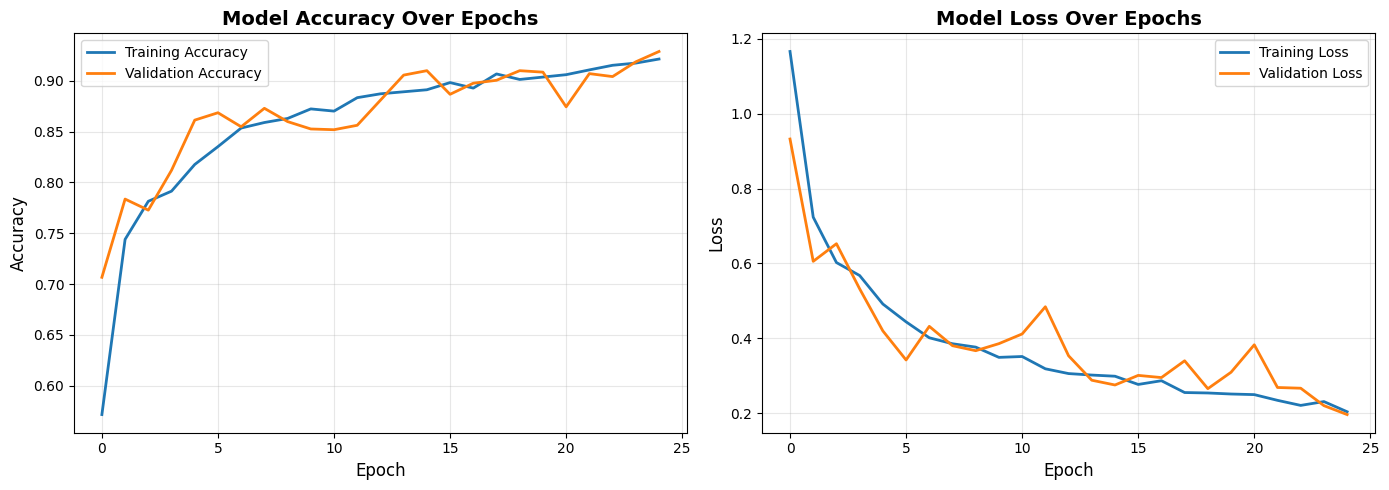

Training plots saved as 'training_results.png'

FINAL RESULTS
Training Accuracy:   0.9214 (92.14%)
Validation Accuracy: 0.9288 (92.88%)
Training Loss:       0.2042
Validation Loss:     0.1967


In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training plots saved as 'training_results.png'")

# Print final
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n{'='*50}")
print("FINAL RESULTS")
print(f"{'='*50}")
print(f"Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Training Loss:       {final_train_loss:.4f}")
print(f"Validation Loss:     {final_val_loss:.4f}")
print(f"{'='*50}")

## Evaluation

In [12]:
# Get predictions on validation set
print("Generating predictions on validation set...")
val_generator.reset()
predictions = model.predict(val_generator, steps=len(val_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Print classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# Calculate overall accuracy
correct_predictions = np.sum(predicted_classes == true_classes)
total_predictions = len(true_classes)
overall_accuracy = correct_predictions / total_predictions

print(f"\nOverall Validation Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")

Generating predictions on validation set...
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane     0.9209    0.8828    0.9014       145
         car     0.9791    0.9689    0.9740       193
         cat     0.8846    0.7797    0.8288       177
         dog     0.8116    0.8000    0.8058       140
      flower     0.8783    0.9881    0.9300       168
       fruit     0.9852    1.0000    0.9926       200
   motorbike     0.9273    0.9745    0.9503       157
      person     0.9949    0.9898    0.9924       197

    accuracy                         0.9288      1377
   macro avg     0.9227    0.9230    0.9219      1377
weighted avg     0.9287    0.9288    0.9278      1377


Overall Validation Accuracy: 0.9288 (92.88%)
Correct Predictions: 1279/1377


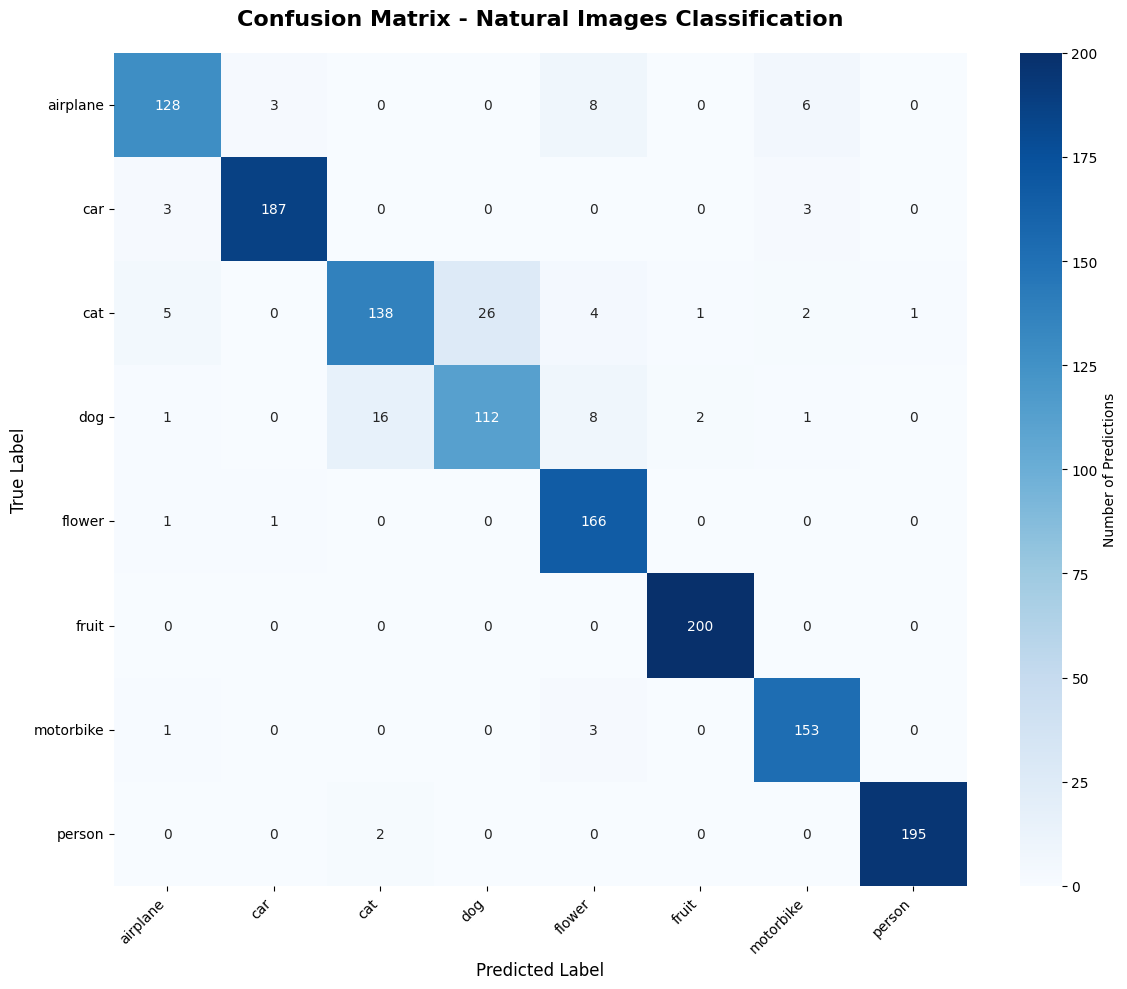

Confusion matrix saved as 'confusion_matrix.png'

Per-Class Accuracy:
----------------------------------------
airplane       : 0.8828 (88.28%)
car            : 0.9689 (96.89%)
cat            : 0.7797 (77.97%)
dog            : 0.8000 (80.00%)
flower         : 0.9881 (98.81%)
fruit          : 1.0000 (100.00%)
motorbike      : 0.9745 (97.45%)
person         : 0.9898 (98.98%)


In [13]:
# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Number of Predictions'})
plt.title('Confusion Matrix - Natural Images Classification', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as 'confusion_matrix.png'")

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 40)
for i, class_name in enumerate(class_labels):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:15s}: {class_acc:.4f} ({class_acc*100:.2f}%)")

## Test Predictions on Sample Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


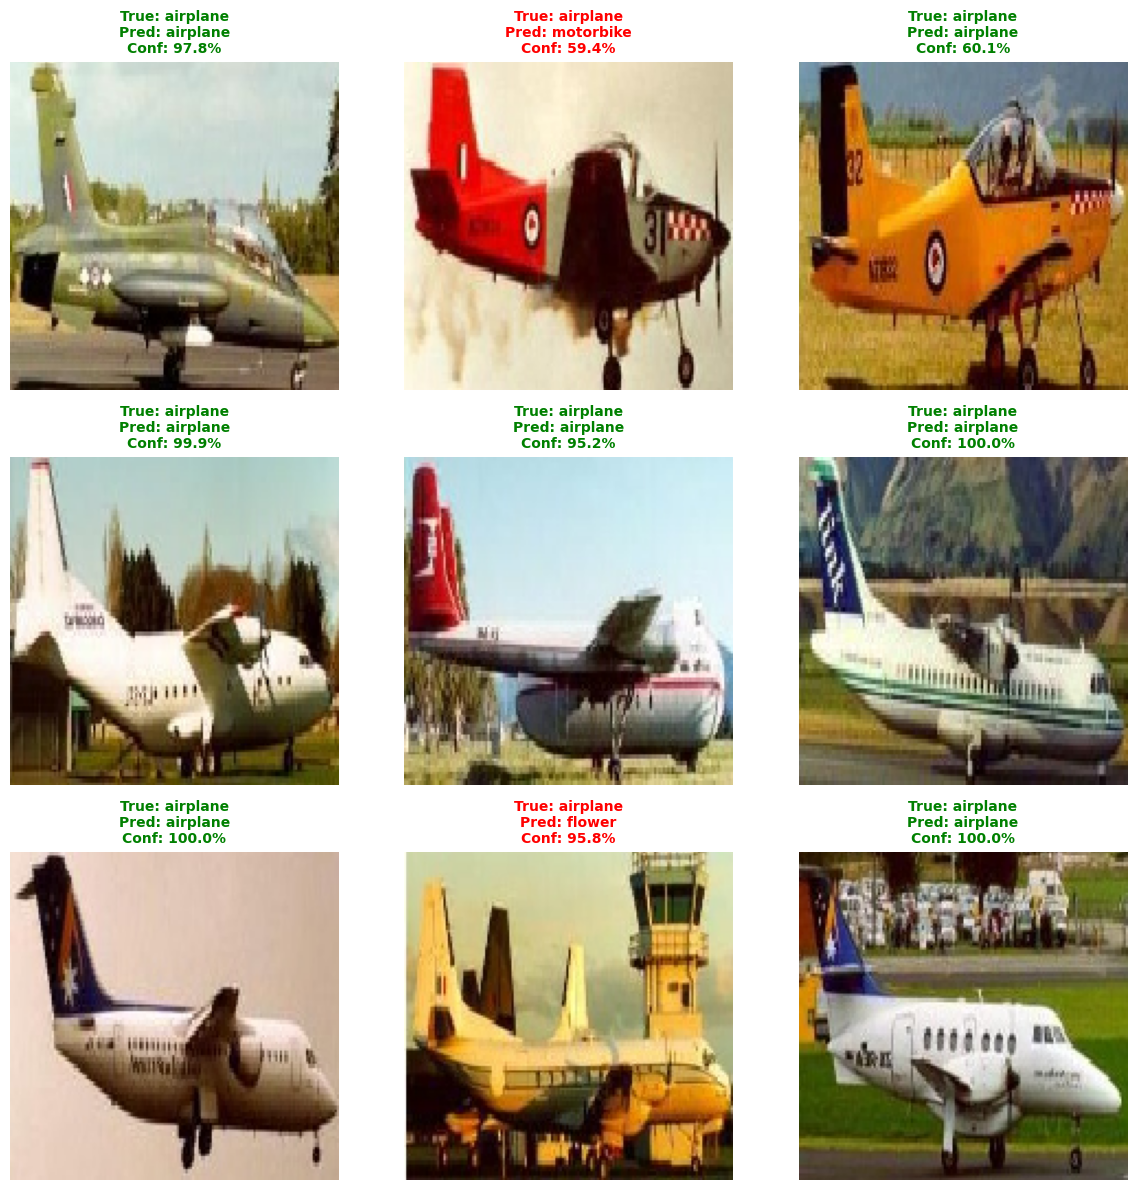

Sample predictions saved as 'sample_predictions.png'


In [14]:
# Get some sample predictions
val_generator.reset()
sample_batch = next(val_generator)
sample_images = sample_batch[0][:9]  # First 9 images
sample_labels = sample_batch[1][:9]

# Make predictions
sample_predictions = model.predict(sample_images)
sample_pred_classes = np.argmax(sample_predictions, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

# Plot predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(sample_images[i])

    true_label = class_labels[sample_true_classes[i]]
    pred_label = class_labels[sample_pred_classes[i]]
    confidence = sample_predictions[i][sample_pred_classes[i]] * 100

    # Color code: green if correct, red if wrong
    color = 'green' if sample_true_classes[i] == sample_pred_classes[i] else 'red'

    axes[i].set_title(
        f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
        color=color, fontsize=10, fontweight='bold'
    )
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample predictions saved as 'sample_predictions.png'")